<h1><center><font size="6"> Kaggle Project: Credit Card Fraud Detection</font></center></h1>

<h2><center><font size="4"> https://www.kaggle.com/mlg-ulb/creditcardfraud </font></center></h2>

## Table of  Contents
1. [Initialization](#1)
    1. [Load packages](#11)
    1. [Define Metadata](#12)   
1. [Load, Validate, and Split the Dataset](#2)
    1. [Memory Reducion](#21)
    1. [Feature - Target Split](#22)
    1. [Train - Test Split](#23)
    1. [Create Validation fold](#24)
1. [Model 1: Simple RF Classifier Model](#3)
    1. [Initialize RF Classifier](#31)
    1. [Evaluate Model Perfomance](#32)
1. [Model 2: Hyperparameter Tuning](#4)
    1. [Instantiate Classifiers](#41)
    1. [Initialize the search Space](#42)
    1. [Tune the Classifier](#43)
    1. [Compare the Performance of Tuned Classifiers](#44)
1. [Model 3: Ensamble - Voting Classifier](#5)
    1. [Initialize and Fit Voting Classifier](#51)
    1. [Evaluate Model 3](#52)

1. [Conclusion](#6)



## <a id='1'>1. Initialization</a>  

### <a id='11'>A. Load Packages</a>  

In [1]:
import os
import sys
# ------------------------------------------------------------------------------------------------------------------------------
# pandas is a Python library written for data manipulation and analysis. 
# In particular, it offers data structures and operations for manipulating numerical tables and time series.
import pandas as pd 
# NumPy is a Python library for adding support for large, multi-dimensional arrays and matrices, 
# along with a large collection of high-level mathematical functions to operate on these arrays. 
import numpy as np
# ------------------------------------------------------------------------------------------------------------------------------
# Visualization
# Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy. It  
# provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn is a data visualization library built on top of matplotlib and closely integrated with pandas data structures.
import seaborn as sn

# ------------------------------------------------------------------------------------------------------------------------------
# split into train and test set 
from sklearn.model_selection import train_test_split
# StratifiedKFold, which is a cross-validation object is a variation of KFold that returns stratified folds. The folds are made 
# by preserving the percentage of samples for each class.
from sklearn.model_selection import StratifiedKFold
# ------------------------------------------------------------------------------------------------------------------------------
# Classifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# ------------------------------------------------------------------------------------------------------------------------------
# Performance evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# ------------------------------------------------------------------------------------------------------------------------------
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
# ------------------------------------------------------------------------------------------------------------------------------
# The shuffle() method takes a sequence, like a list, and reorganize the order of the items.
from sklearn.utils import shuffle
# Python Counter is a container that will hold the count of each of the elements present in the container. The counter is a 
# sub-class available inside the dictionary class.
from collections import Counter
# ------------------------------------------------------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 


### <a id='12'>B. Define Metadata</a>  

In [2]:
# Define the name of the target class column here instead of manually typing it out everywhere.
target_class_name = 'Class'

# Fill in the names of what we want to call the 0 and 1 class. Here, negative class is 'Non-Fraud' (0) and positive class is 'Fraud' (1).
labels = ['Non-Fraud', 'Fraud']

input_file_name = 'creditcard.csv'

## <a id='2'>2. Load, Validate, and Split the Dataset</a> 

In [3]:
# Load the data
df = pd.read_csv('C:/Behnaz/Data Science/Kaggle Dataset/' + input_file_name)
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
132413,79978.0,-0.973497,0.504589,1.183219,0.153867,0.502028,-0.739310,0.483130,0.053675,-0.241560,...,-0.262486,-0.554637,0.514307,0.003543,-0.132364,0.111146,0.198196,0.034730,4.49,0
179261,123990.0,-0.179404,0.731639,-1.351349,0.321764,0.295712,-0.913453,0.536974,0.146279,0.211220,...,0.102831,0.402716,0.453771,1.005365,-2.126156,-0.340499,0.189966,0.308093,75.91,0
63818,50879.0,-0.684061,0.985100,1.282391,-0.410617,0.305796,-0.140418,0.784880,-0.134384,-0.421872,...,0.011181,0.112462,-0.383430,-0.174391,0.331004,1.280578,-0.287476,0.030996,8.20,0
248036,153778.0,-2.162523,-1.480503,1.503203,-1.473792,2.050537,-2.171192,-0.196182,-0.362972,-0.902982,...,-0.752570,-1.534654,-0.510375,0.016767,0.543491,-0.019871,-0.136737,-0.219637,9.50,0
38859,39585.0,-0.502641,0.241233,1.872881,-1.036410,-0.527269,0.136339,0.201768,0.098717,-2.063816,...,-0.321627,-0.522643,-0.036917,0.058287,-0.140022,1.046189,0.007542,0.055675,45.66,0


Let's validate the dataset to see if  
- there are some unwanted headers.
- there are any problem in the tail.

In [4]:
display(df.head(5),df.tail(5))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


#### $\rightarrow$ No trouble with loading the data, the head and tail.

### <a id='21'>A. Memory Reducion </a> 

In [5]:
# In Python, integer data types do not support Nulls. Therefore, when we want to reduce memory, we need to impute Nulls with a 
# number. Then, replace it with Nulls after converting data to integer.

# The following function imputes Nulls with a defined imputed_val.
def null_imputation_function(dataframe, col, NA_dict, imputed_val):
    '''
    inputs: 
    dataframe: whose column has nulls that has to be imputed with imputed_val
    col: column of datafram that has nulls.
    NA_dict: records the null columns
    
    Returns: the imputed dataframe column, dictionary with {null_col_name: imputed_val} and indices of all rows with nulls.
    
    '''
    
    # Store the existence of nulls in this column as a flag that can be utilized again after the data conversion 
    # because Integer datatype does not support NA, therefore, NA needs to be filled
    null_existence_col_flag = np.isfinite(dataframe[col]).all()
    # Note that np.isfinite is equally applicable for both np.nan and infinite numbers
    # It will return False if there is atleast 1 null or infinite value in the column
    
    null_indices_list = []
    
    #Check if every item in a column is finite, otherwise fill nulls with the (minimum value - 1)
    if not null_existence_col_flag: 
        
        # Store the null indices in a list
        null_indices_list = dataframe[dataframe[col].isnull()].index.tolist()
        
        dataframe[col].fillna(imputed_val, inplace=True)  

        # Record the imputed value so that we can bring it back outside of the function if needed
        NA_dict[col] = imputed_val
        
    return dataframe[col], null_existence_col_flag, NA_dict, null_indices_list

# ------------------------------------------------------------------------------------------------------------------------------
# The following function converts float to integer:
def float_to_int_conversion_function(dataframe, col, mn, mx):
    '''
    Inputs: 
    dataframe:  dataframe containing the col which has been proven previously that it can be converted to an int.
    mn, mx: the minimum and maximum values of the column. 
    - Note that the dataframe should not have any nulls 
    
    Logic: The code downcasts the float64 into uint8,16,32,64 if its a strictly positive integer or int8,16,32, or 64 if its 
    a signed integer
    
    Returns: dataframe column with the changed datatype.
    '''
    
    # if the minimum is positive, then the numbers need unsigned integers
    if mn >= 0:
        if mx < 255:
            # (2 ** 8) - 1 = 255. Therefore, the column with max smaller than 255 can be converted into 8-bit unsigned 
            # integer (range: 0 through 255 decimal).
            dataframe.loc[:,col] = dataframe[col].astype(np.uint8)
        elif mx < 65535:
            dataframe.loc[:,col] = dataframe[col].astype(np.uint16)
        elif mx < 4294967295:
            dataframe.loc[:,col] = dataframe[col].astype(np.uint32)
        else:
            dataframe.loc[:,col] = dataframe[col].astype(np.uint64)
    else:
        # allocate signed 
        # if mn is greater than -128 and mx is smaller than 127, conver the column into int8.
        if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
            dataframe.loc[:,col] = dataframe[col].astype(np.int8)
        elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
            dataframe.loc[:,col] = dataframe[col].astype(np.int16)
        elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
            dataframe.loc[:,col] = dataframe[col].astype(np.int32)
        elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
            dataframe.loc[:,col] = dataframe[col].astype(np.int64)
    
    return dataframe[col]


# ------------------------------------------------------------------------------------------------------------------------------
def reduce_mem_usage_function(dataframe, print_ongoing_column_change = True, percentile_threshold = 0.01):
    
    '''
    Inputs: 
    dataframe: dataframe to be compressed.
    print_ongoing_column_change: a boolean variable that indicates the ongoing variable change gets printed or not.
    int_difference_cutoff is used to make criterion to convert floats to ints more stringent.
    
    Logic: The column numbers are hardcoded as 8, 16, 32 or 64 bit depending on the range of cell vals.
    columns with some infinite values are hard coded with nulls with min - 1.
    Returns: the compressed dataframe and the NAdict containing the col names as keys and their imputed values as values.
    
    '''
    
    #from collections import Counter
    
    #Calculate the memory usage in MB. This scaling factor is more precise than dividing by 1e6
    start_mem_usg = dataframe.memory_usage().sum() / 1024**2 
    print("Memory usage of dataframe is {} MB".format(round(start_mem_usg,2)))

    # We are replacing Null/infinity with min() - 1. Therefore, to keep track of columns, which had Null/infinity, we can 
    # initialize the following  dictionary.
    NA_dict = Counter()
       
    # The code iterates through the columns that are not strings.   
    for col in dataframe.columns:
        if dataframe[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            # IsInt recognizes the values where the decimal part of the value is very smaller than its integer part.
            IsInt = False
            mx = dataframe[col].max()
            mn = dataframe[col].min()

            
            # We can change how strict the comparison is using the percentile_threshold

            # By default, we want 99% of our numbers to be above 10 
            # (which is really 10*0.99 ie 10x the maximum value of the error due to rounding off the decimal)
            IsInt = np.abs(dataframe[col].quantile(q=percentile_threshold)) > 10

            # Make sure to do the above before the imputation of nulls (otherwise your statistical measures will be skewed)
            
            # Make Integer/unsigned Integer datatypes
            if IsInt:   
                # In Python, integer data types do not support Nulls. Therefore, we need to impute Nulls with a number. 
                # Then, replace it with Nulls after converting data to integer.
                dataframe.loc[:,col], null_existence_col_flag, \
                NA_dict, null_indices_list = null_imputation_function(dataframe, col, NA_dict, imputed_val = mn-1)

                dataframe.loc[:,col] = float_to_int_conversion_function(dataframe, col, mn, mx)

                # Bring back the nulls in those indices we stored before for the subset of the columns for which nulls 
                #originally existed
                if not null_existence_col_flag:
                    print(col, len(null_indices_list))
                    dataframe.loc[null_indices_list, col] = np.nan

            # Make float datatypes 32 bit only when the underlying numbers are not of type integer
            else:
                dataframe.loc[:,col] = dataframe[col].astype(np.float32)                
            
            if print_ongoing_column_change:
                
                # Print new column type
                print("Column {} dtype after is {} ".format(col, dataframe[col].dtype))
                print("******************************")
    
    # Print final result
    print("___Memory usage after Data size reduction:___")
    
    mem_usg = dataframe.memory_usage().sum() / 1024**2 
    print("Memory usage is {} MB ".format(round(mem_usg,2)))
    
    print("Final data size is {} percent of initial size".format(round((100*mem_usg/start_mem_usg),2)))
    return dataframe, NA_dict

In [6]:
df, df_Nulls = reduce_mem_usage_function(df, print_ongoing_column_change = True, percentile_threshold = 0.01)

Memory usage of dataframe is 67.36 MB
Column Time dtype after is uint32 
******************************
Column V1 dtype after is float32 
******************************
Column V2 dtype after is float32 
******************************
Column V3 dtype after is float32 
******************************
Column V4 dtype after is float32 
******************************
Column V5 dtype after is float32 
******************************
Column V6 dtype after is float32 
******************************
Column V7 dtype after is float32 
******************************
Column V8 dtype after is float32 
******************************
Column V9 dtype after is float32 
******************************
Column V10 dtype after is float32 
******************************
Column V11 dtype after is float32 
******************************
Column V12 dtype after is float32 
******************************
Column V13 dtype after is float32 
******************************
Column V14 dtype after is float32 
************

### <a id='22'>B. Feature - Target Split </a> 

In [7]:
X = df.drop(target_class_name, axis=1)
y = df[target_class_name]

### <a id='23'>C. Train - Test Split</a> 

In [8]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print('Length of (train): {} | positives in y (train): {}'.format(len(X_train), sum(y_train)))
print('Length of (test): {} | positives in y (test): {}'.format(len(X_test), sum(y_test)))

Length of (train): 227845 | positives in y (train): 394.0
Length of (test): 56962 | positives in y (test): 98.0


### <a id='24'>D. Create Validation fold</a> 

In [10]:
# Split the train set into validation train and test set. Then, use the custom resampling technique pnly for the validation train set.
# Keep a holdout set that has not been sampled
cv_fold_X_train, cv_fold_X_test, cv_fold_y_train, cv_fold_y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42, stratify = y_train)
# Use the custom func. to handel class imbalance problem
X_train_resampled, y_train_resampled = Custom_resampling_function(cv_fold_X_train, cv_fold_y_train, pos_upsampling_ratio=4, neg_upsampling_ratio=2)

## <a id='3'>3. Model 1: Simple RF Classifier model</a> 

### <a id='31'>A. Initialize RF Classifier</a> 


In [11]:
# Initialize a classifier object with default params
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### <a id='32'>B. Evaluate Model 1 Performance</a> 


In [39]:
# Custom Evaluation Function:
def classification_Evaluation_metrics_function(X_test, y_test, classifier, ModelSpe = 'Clarification', metrics_df_flag=True):
    
    '''
    Inpute: 
    X_train - target dataframe
    y_train - target labels
    sklearn classifier object that has been fitted with the training data outside of the function; 
    Model specifications that we want to avaluate its result.
    
    Logic: Calculates and displays the Accuracy, Classification report, ROC Curve, Confusion Matrix.
    
    Returns: If metrics_df flag is set, return dictionary containing relevant metrics for classification.
    
    ''' 
    # Accuracy
    Acc = round(classifier.score(X_test, y_test),2)   
    print("Accuracy of " + ModelSpe + " =  {} % ".format(Acc * 100))
    
    # Precision, Recall, F1-Score, Support
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test,y_pred,target_names=labels))

    # --------------------------------------------------------------------------------------------------------------------------
    # ROC Curve
    FP_rate, TP_rate, threshold = roc_curve(y_test, y_pred)  
    y_pred_Proba = classifier.predict_proba(X_test)[:,1]
                   
    
    f = plt.figure(1)
    plt.figure(figsize=(10,6))
    plt.plot([0, 1], [0, 1], 'c--')
    plt.plot(FP_rate, TP_rate, 'g-', linewidth=3)
    plt.title('Receiver Operating Characteristic (ROC) Curve - ' + ModelSpe, fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)    
    plt.axis([-0.01,1,0,1])
    f.show()
    
    roc_auc_val = float("{0:.2f}".format(roc_auc_score(y_test, y_pred_Proba)))
    print('The ROC-AUC Score ({}) = {}'.format(ModelSpe, roc_auc_val))

    # --------------------------------------------------------------------------------------------------------------------------
    # Confusion Matrix
    confusion_matrix_test = confusion_matrix(y_test, y_pred)
    
    g = plt.figure(1)
    x_axis_labels = ['Non-Fraud','Fraud'] # labels for x-axis
    y_axis_labels = ['Non-Fraud','Fraud'] # labels for y-axis
    ax = sn.heatmap(confusion_matrix_test,cmap="YlGnBu", annot=True, annot_kws={"size": 16},xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size
    plt.title('Confusion Matrix - '+ ModelSpe, fontsize = 20) # title with fontsize 20
    plt.xlabel('Predicted Label', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True Label', fontsize = 15) # y-axis label with fontsize 15
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
    g.show()

    # --------------------------------------------------------------------------------------------------------------------------
    # Note: his part will be exlained in section C.
    # The precision value when recall is just above the recall_threshold    
    # from sklearn.metrics import precision_recall_curve  
    precision, recall, _ = precision_recall_curve(y_test, y_pred_Proba)   
    Precision_at_Recall = precision[recall>0.85][-1]
    # --------------------------------------------------------------------------------------------------------------------------
    if metrics_df_flag:
        # The precision value when recall is just above the recall_threshold
        metrics_dict = {}

        

        # Metrics from the classification report
        # We are only interested in the minority class which is 1
        metrics_dict['Pos_Precision'] = classification_report(y_test, y_pred, output_dict=True)['1.0']['precision']
        metrics_dict['Pos_Recall'] = classification_report(y_test, y_pred, output_dict=True)['1.0']['recall']
        metrics_dict['Pos_F1'] = classification_report(y_test, y_pred, output_dict=True)['1.0']['f1-score']

        # Metric from the ROC AUC curve
        metrics_dict['ROC-AUC'] = roc_auc_val

        
        # Metrics from the confusion matrix
        metrics_dict['TN'] = confusion_matrix_test[0][0]
        metrics_dict['TP'] = confusion_matrix_test[1][1]
        metrics_dict['FN'] = confusion_matrix_test[1][0]
        metrics_dict['FP'] = confusion_matrix_test[0][1]

        metrics_dict['Precision_at_Recall (85%)'] = Precision_at_Recall
        
        return metrics_dict

Accuracy of Model 1 =  100.0 % 
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.93      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

The ROC-AUC Score (Model 1) = 0.98


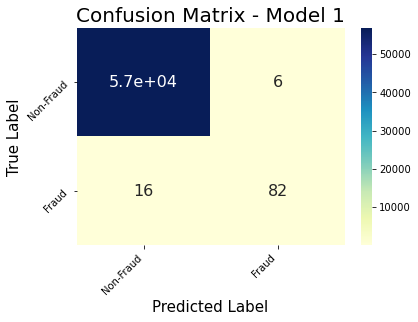

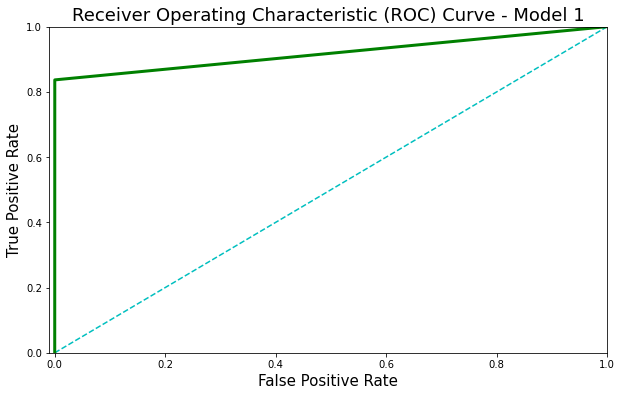

In [40]:
Model_1 = classification_Evaluation_metrics_function(X_test, y_test, classifier, 
                                                 ModelSpe = 'Model 1', metrics_df_flag=True)

## <a id='4'>4. Model 2: Hyperparameter Tuning</a> 

### <a id='41'>A. Instantiate Classifiers</a> 


In [14]:
# Store the fitted models in a dictionary to be called in a subsequent subroutine
classifier_dict = Counter()

classifier_dict['Random_Forest'] = RandomForestClassifier
classifier_dict['Extra_Tree'] = ExtraTreesClassifier
classifier_dict['Gradient_Boosting'] = GradientBoostingClassifier
classifier_dict['Light_GBM'] = LGBMClassifier
classifier_dict['XGBoost'] = XGBClassifier

### <a id='42'>B. Initialize the search Space</a> 

In [15]:
# Use this to manually store the search space
hyper_param_space_dict = Counter()

#### Random Forest Search Space

In [16]:
# Higher Number of decision trees used in the ensemble will increase the accuracy
n_estimators = [20, 50, 100]

# Increasing number of levels in tree may cause overfitting
max_depth = [6, 7, 10]

# Higher number of samples required to split a node will reduce overfitting
min_samples_split = [2,5, 10]

# Higher number of samples required at each leaf node will also reduce overfitting
min_samples_leaf = [2,3,4,5, 10]


# Create the grid for the random search. 
hyper_param_space_dict['Random_Forest'] = {'n_estimators': n_estimators,
                                'max_depth':max_depth,
                                'min_samples_split':min_samples_split,
                                'min_samples_leaf':min_samples_leaf,

                                'random_state': [42],
                                'warm_start':[True]}


#### Extra Tree Search Space


In [17]:
hyper_param_space_dict['Extra_Tree'] = {
    
            'random_state': [42],
            'warm_start':[True],
    
            'n_estimators':[50, 100, 200],
            'max_depth': [10, 15, 18],
            'min_samples_split': [4, 6, 10],
            'min_samples_leaf': [2, 3, 5]    
        }

#### Gradient Boosting Search Space


In [18]:
hyper_param_space_dict['Gradient_Boosting'] = {
    
    'random_state': [42],
    'warm_start':[True],
    'n_iter_no_change':[5],
    'validation_fraction':[0.1],
    
    'n_estimators':[100, 200],
    'subsample':[0.8, 1],

    'max_depth': [7, 10, 15],
    'min_samples_split': [4, 6, 10],
    'min_samples_leaf': [2, 3, 5]
    
}

#### Light GBM Search Space


In [19]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

hyper_param_space_dict['Light_GBM'] = {
    
    'random_state': [42],
    
    'n_estimators':[100, 200],
    'subsample':[0.8, 1],
    
    'max_depth': [7, 10, 15], 
    'min_data_in_leaf': [2, 3, 5, 10], 
    # Note that the min_samples_leaf is renamed as min_data_in_leaf
    
    'objective':['binary'],
    'eval_metric':['binary_logloss'],
}


#### XGBoost Search Space

In [20]:
# https://xgboost.readthedocs.io/en/latest//parameter.html
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst

hyper_param_space_dict['XGBoost'] = {
    
    'random_state': [42],
    'n_estimators':[100],
    'max_depth': [3, 5, 7], 
    'colsample_bytree':[0.5, 0.7, 1],
    
    'objective':['binary:logistic'],
    'eval_metric':['aucpr'],# default is eval_metric:error
    'early_stopping_rounds':[5],
}


### <a id='43'>C. Tune the Classifier</a> 


We use the following fuction for Gridsearch, which uses precision_at_recall_threshold score to tune the model.

In [21]:
# the follwing function returns accuracy, precision recall, F1 score and roc_auc
def metrics_store_function(optimised_model, cv_fold_X_test, cv_fold_y_test):
    
    '''
    Args: The model with the best combo of hyperparams, X & Y validation data
    Logic: After generating the predictions using the passed model, 
    calls the builtin metrics for scoring on the above predictions
    Returns: The Accuracy, Precision, Recall, F1 Score, AUC ROC
    
    '''
    
    classification_metrics_dict = Counter()
    # Predict on the validation folds that have NOT been upsampled
    val_pred = optimised_model.predict(cv_fold_X_test)
    
    classification_metrics_dict['accuracy'] = optimised_model.score(cv_fold_X_test, cv_fold_y_test)
    classification_metrics_dict['precision'] = precision_score(cv_fold_y_test, val_pred)
    classification_metrics_dict['recall'] = recall_score(cv_fold_y_test, val_pred)
    classification_metrics_dict['f1'] = f1_score(cv_fold_y_test, val_pred)
    classification_metrics_dict['roc_auc'] = roc_auc_score(cv_fold_y_test, val_pred)

    return classification_metrics_dict

#-------------------------------------------------------------------------------------------------------------------------------
# Use a cutome precision_at_Recall_Threshold score to tune the model using GridSearch
def precision_at_recall_threshold_function(y_test, predicted_proba, Recall_Threshold=0.85):
    '''
    Inputs: The true labels, predicted probabilities and the recall threshold for which precision needs to be computed
    
    Logic: Using the precision recall curve method from sklearn. Then, the precision at a given Recall_Threshold is calculated.
    
    Returns: "the first Precision score when Recall is greater than Recall_Threshold." 
    
    '''
    # from sklearn.metrics import precision_recall_curve    
    precision, recall, _ = precision_recall_curve(y_test, predicted_proba)    
    return precision[recall>Recall_Threshold][-1]

def tune_grid_search_function(cv_fold_X_train, cv_fold_y_train, cv_fold_X_test, cv_fold_y_test,
hyper_param_space, classifier_type = RandomForestClassifier, **kwargs):
    
    '''
    Args: the train and test folds, a dictionary of the hyperparams for the uninstantiated classifier model
    the classifier type and any key word args 
    including those for custom scoring functions passed to the GridSearchCV
    
    Logic: GridSearchCV is run for the above combo (stratification is on by default)
    
    The metrics are calculated with the optimised model on the validation fold 
    
    Returns: hyperparam_results contains the best params for the classifier model; relevant metrics
    
    '''

    # This is to store the best_params and metrics from each fold 
    hyperparam_results = Counter()
    
    # Edited on the 14th of May 2020 to make the custom scorer optional
    if kwargs['is_custom_scorer']:
        
        # get the custom_scoring_function object from the kwargs dictionary
        custom_scoring_function = kwargs['custom_scoring_function']
        
        # ... and pass it onto sklearn's make_scorer
        from sklearn.metrics import make_scorer
        custom_scorer = make_scorer(custom_scoring_function, greater_is_better=True, needs_proba=True)

        search_object = GridSearchCV(classifier_type(), 
                                      hyper_param_space, scoring = custom_scorer, cv = 3, 
                                      verbose = 10, n_jobs = 1)

    else:
        # Notice how the GridSearchCV doesnt have the scoring param
        search_object = GridSearchCV(classifier_type(), 
                                  hyper_param_space, cv = 3, 
                                  verbose = 10, n_jobs = 1)
    
    # Actually fitting the gridsearch object on the subset of the training data
    model = search_object.fit(cv_fold_X_train, cv_fold_y_train)
    
    # Allows the later plotting of the grid search improvements over time
    internal_cv_score_list = [x for x in model.cv_results_['mean_test_score']]
    
    hyperparam_results['internal_grid_search_scores'] = internal_cv_score_list
    
    # We really need just 2 sets of data: the best hyperparam combo and validation performance estimate
    hyperparam_results['best_params'] = model.best_params_
       
    
    # Get the model with the best combination of hyperparams, use it to predict on validation fold
    optimised_model = model.best_estimator_
    

    # Notice how the classification metrics are calculatedd on the unresampled cv_fold_X_test
    # .... and store all the relevant classification metrics
    classification_metrics_dict = metrics_store_function(optimised_model, cv_fold_X_test, cv_fold_y_test)
  
    classification_metrics_dict['f2'] = fbeta_score(cv_fold_y_test, optimised_model.predict(
                            cv_fold_X_test), average='weighted', beta=2)
    
    if kwargs['custom_scoring_function'] == precision_at_recall_threshold_function:
        
        recall_threshold = kwargs['recall_threshold']
        
        classification_metrics_dict['precision_at_recall'+ str(recall_threshold)] = precision_at_recall_threshold_function(
            cv_fold_y_test, optimised_model.predict_proba(cv_fold_X_test)[:,1], 
            Recall_Threshold=0.85)
    
    hyperparam_results['classification_metrics'] = classification_metrics_dict
    
    return hyperparam_results

In [22]:
%%time

# Initialize a dictionary to hold the optimum hyperparams
hyperparam_results_dict = Counter()

for classifier_name, classifier_type in classifier_dict.items():
    
    print('Tuning {}'.format(classifier_name))
    
    # Get the hyperparams that were manually defined
    hyper_param_space = hyper_param_space_dict[classifier_name]
    
    # Store each of the classifier's hyperparams, optimized model and the classifier's metrics
    hyperparam_results_dict[classifier_name] = tune_grid_search_function(
    cv_fold_X_train, cv_fold_y_train, cv_fold_X_test, cv_fold_y_test, 
    hyper_param_space, classifier_type = classifier_type, 
    custom_scoring_function = precision_at_recall_threshold_function,
    is_custom_scorer = True, recall_threshold = 0.85)
    
    # Print the results after tuning
    print('The best results are {}'.format(hyperparam_results_dict[classifier_name]['best_params']))

    print('---' * 35)

Tuning Random_Forest
Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True, score=0.833, total=   7.0s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True, score=0.064, total=   7.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True, score=0.039, total=   7.0s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.0s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True, score=0.833, total=  16.6s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.6s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True, score=0.037, total=  16.8s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.4s remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True, score=0.034, total=  15.9s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True, score=0.833, total=  32.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True, score=0.083, total=  32.0s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.2min remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True, score=0.032, total=  32.7s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.8min remaining:    0.0s


[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True, score=0.826, total=   6.2s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True, score=0.054, total=   6.4s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True, score=0.037, total=   6.4s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.826, total=  16.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  ma

[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.833, total=  31.3s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.060, total=  31.0s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.036, total=  33.1s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True, score=0.849, total=   6.4s
[CV] max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True 


[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.826, total=  16.4s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.027, total=  15.8s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.042, total=  15.9s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.833, total=  30.5s
[CV] max_depth=6, min_samples_leaf=4, min_samples_split=10, n_estimators=100, random_state=42, warm_start=Tru

[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True, score=0.826, total=   5.9s
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True, score=0.083, total=   6.1s
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True, score=0.012, total=   6.3s
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True, score=0.818, total=  15.4s
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True 


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True, score=0.841, total=  37.6s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True, score=0.108, total=  34.5s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True, score=0.023, total=  34.3s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True, score=0.818, total=   7.0s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True 
[CV

[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.833, total=  18.2s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.060, total=  18.4s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.070, total=  18.6s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.833, total=  36.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV] 

[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True, score=0.833, total=   7.7s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True, score=0.041, total=   7.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True, score=0.036, total=   7.1s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.833, total=  17.5s
[CV] max_depth=7, min_samples_leaf=4, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.833, total=  33.9s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.063, total=  34.5s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.057, total=  34.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=2, n_estimators=20, random_state=42, warm_start=True, score=0.826, total=   6.8s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=2, n_estimators=20, random_state=42, warm_start=T

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True, score=0.857, total=  23.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True, score=0.107, total=  23.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42, warm_start=True, score=0.061, total=  23.9s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=True, score=0.857, total=  47.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42, warm_start=Tru

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True, score=0.849, total=   9.6s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True, score=0.111, total=   9.5s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=20, random_state=42, warm_start=True, score=0.065, total=   9.6s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True, score=0.841, total=  23.6s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=5, n_estimators=50, random_state=42, warm_start=True 


[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.833, total=  47.6s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.089, total=  47.4s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100, random_state=42, warm_start=True, score=0.078, total=  47.4s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=20, random_state=42, warm_start=True, score=0.849, total=   9.4s
[CV] max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=20, random_state=42, warm_star

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.833, total=  23.8s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.095, total=  23.7s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.053, total=  24.0s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.833, total=  47.3s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_s

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 146.2min finished


The best results are {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42, 'warm_start': True}
---------------------------------------------------------------------------------------------------------
Tuning Extra_Tree
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True, score=0.833, total=   2.8s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True, score=0.039, total=   2.8s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True, score=0.046, total=   2.8s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.3s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42, warm_start=True, score=0.841, total=   5.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.0s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42, warm_start=True, score=0.054, total=   5.5s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.5s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=100, random_state=42, warm_start=True, score=0.109, total=   5.5s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.0s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True, score=0.841, total=  11.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   36.2s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True, score=0.047, total=  11.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   47.2s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True, score=0.088, total=  11.4s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=50, random_state=42, warm_start=True 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   58.6s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=50, random_state=42, warm_start=True, score=0.833, total=   3.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=50, random_state=42, warm_start=True, score=0.068, total=   2.8s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=50, random_state=42, warm_start=True, score=0.103, total=   2.8s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state=42, warm_start=True, score=0.833, total=   5.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state=42, warm_start=Tru

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=200, random_state=42, warm_start=True, score=0.833, total=  11.4s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=200, random_state=42, warm_start=True, score=0.070, total=  10.9s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=200, random_state=42, warm_start=True, score=0.083, total=  11.2s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.833, total=   2.8s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=50, random_state=42, warm_star

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.833, total=   5.6s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.050, total=   5.6s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.061, total=   5.6s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.826, total=  11.2s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, w

[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True, score=0.849, total=   4.1s
[CV] max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True, score=0.141, total=   4.0s
[CV] max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=50, random_state=42, warm_start=True, score=0.061, total=   4.2s
[CV] max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=100, random_state=42, warm_start=True, score=0.849, total=   8.1s
[CV] max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=100, random_state=42, warm_start=Tru

[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True, score=0.833, total=  16.2s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True, score=0.067, total=  15.8s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=4, n_estimators=200, random_state=42, warm_start=True, score=0.159, total=  16.2s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=6, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=6, n_estimators=50, random_state=42, warm_start=True, score=0.841, total=   4.1s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=6, n_estimators=50, random_state=42, warm_start=T

[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state=42, warm_start=True, score=0.891, total=   9.4s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state=42, warm_start=True, score=0.156, total=   8.9s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state=42, warm_start=True, score=0.230, total=   9.2s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=200, random_state=42, warm_start=True, score=0.882, total=  18.4s
[CV] max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=200, random_state=42, warm_star

[CV]  max_depth=18, min_samples_leaf=3, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.874, total=   4.6s
[CV] max_depth=18, min_samples_leaf=3, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=3, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.036, total=   4.5s
[CV] max_depth=18, min_samples_leaf=3, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=3, min_samples_split=10, n_estimators=50, random_state=42, warm_start=True, score=0.327, total=   4.6s
[CV] max_depth=18, min_samples_leaf=3, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=3, min_samples_split=10, n_estimators=100, random_state=42, warm_start=True, score=0.882, total=   9.3s
[CV] max_depth=18, min_samples_leaf=3, min_samples_split=10, n_estimators=100, random_state=42, warm_s

[CV]  max_depth=18, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.841, total=  17.9s
[CV] max_depth=18, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.130, total=  17.3s
[CV] max_depth=18, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True 
[CV]  max_depth=18, min_samples_leaf=5, min_samples_split=10, n_estimators=200, random_state=42, warm_start=True, score=0.197, total=  17.9s


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 35.8min finished


The best results are {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200, 'random_state': 42, 'warm_start': True}
---------------------------------------------------------------------------------------------------------
Tuning Gradient_Boosting
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.012, total=  45.5s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.4s remaining:    0.0s


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.040, total=  15.4s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.015, total=  13.2s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.009, total=  37.9s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total=  19.4s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total=  16.9s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.5min remaining:    0.0s


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.012, total=  45.6s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.2min remaining:    0.0s


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.040, total=  15.5s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.5min remaining:    0.0s


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.015, total=  13.3s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.7min remaining:    0.0s


[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.009, total=  38.1s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total=  19.5s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total=  16.7s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=6, n_estimators

[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  19.9s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.375, total=  22.0s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.001, total=  30.4s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=10, n_es

[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  24.6s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  26.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.046, total=  16.4s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=6, n_esti

[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.001, total=  13.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  15.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.001, total=  13.3s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=4, n_

[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total=  19.3s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.001, total=  13.0s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  15.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=10

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.001, total= 2.3min
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total= 1.0min
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.035, total=  21.8s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=6, n_

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.048, total=  23.7s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.006, total=  23.3s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.007, total= 2.2min
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=4, n_esti

[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  21.5s
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.462, total= 1.1min
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.026, total= 4.9min
[CV] max_depth=10, min_samples_leaf=3, min_samples_split=10

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  20.4s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  19.8s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total=  55.6s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=6, 

[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  27.0s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total= 7.5min
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.021, total=  27.3s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split

[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total= 2.5min
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.068, total=  31.8s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  41.1s
[CV] max_depth=15, min_samples_leaf=2, min_samples_spl

[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total=  51.6s
[CV] max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.009, total= 5.9min
[CV] max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=100, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.021, total=  49.7s
[CV] max_depth=15, min_samples_leaf=3, min_samples_split=6, n_

[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.526, total= 6.3min
[CV] max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total= 3.7min
[CV] max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total=  34.5s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=4, n

[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=0.8, validation_fraction=0.1, warm_start=True, score=0.002, total=  31.4s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.005, total=  34.6s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=6, n_estimators=200, n_iter_no_change=5, random_state=42, subsample=1, validation_fraction=0.1, warm_start=True, score=0.002, total=  34.8s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=6, n_es

[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed: 337.4min finished


The best results are {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100, 'n_iter_no_change': 5, 'random_state': 42, 'subsample': 1, 'validation_fraction': 0.1, 'warm_start': True}
---------------------------------------------------------------------------------------------------------
Tuning Light_GBM
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.0s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.0s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.0s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.0s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.9s remaining:    0.0s


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.0s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s remaining:    0.0s


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.0s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.9s remaining:    0.0s


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.6s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.5s remaining:    0.0s


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.5s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.0s remaining:    0.0s


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.6s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.5s remaining:    0.0s


[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.6s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.002, total=   2.4s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samp

[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=3, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.5s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=5, n_estimators=100, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=5, n_estimators=100, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.0s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=5, n_estimators=100, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=5, min_chil

[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=10, n_estimators=100, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.0s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=10, n_estimators=100, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=10, n_estimators=100, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   0.9s
[CV] eval_metric=binary_logloss, max_depth=7, min_data_in_leaf=10, n_estimators=100, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, m

[CV]  eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.1s
[CV] eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.1s
[CV] eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=2, n_estimators=100, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_

[CV]  eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=3, n_estimators=100, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.1s
[CV] eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=3, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=3, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.5s
[CV] eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=3, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=3, min_

[CV]  eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   2.1s
[CV] eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.7s
[CV] eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=5, n_estimators=200, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=5, min_

[CV]  eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=10, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.8s
[CV] eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=10, n_estimators=200, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=10, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.7s
[CV] eval_metric=binary_logloss, max_depth=10, min_data_in_leaf=10, n_estimators=200, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, min

[CV]  eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=2, n_estimators=200, objective=binary, random_state=42, subsample=1, score=0.002, total=   2.1s
[CV] eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=3, n_estimators=100, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=3, n_estimators=100, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.1s
[CV] eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=3, n_estimators=100, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=3, min_

[CV]  eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=5, n_estimators=100, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.2s
[CV] eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=5, n_estimators=100, objective=binary, random_state=42, subsample=0.8 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=5, n_estimators=100, objective=binary, random_state=42, subsample=0.8, score=0.002, total=   1.2s
[CV] eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=5, n_estimators=100, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=5, min_

[CV]  eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=10, n_estimators=100, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.1s
[CV] eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=10, n_estimators=100, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=10, n_estimators=100, objective=binary, random_state=42, subsample=1, score=0.002, total=   1.1s
[CV] eval_metric=binary_logloss, max_depth=15, min_data_in_leaf=10, n_estimators=100, objective=binary, random_state=42, subsample=1 
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=10, min

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  3.5min finished


The best results are {'eval_metric': 'binary_logloss', 'max_depth': 7, 'min_data_in_leaf': 2, 'n_estimators': 100, 'objective': 'binary', 'random_state': 42, 'subsample': 0.8}
---------------------------------------------------------------------------------------------------------
Tuning XGBoost
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42 
[07:59:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42, score=0.909, total=   6.9s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42 
[07:59:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42, score=0.176, total=   7.1s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42 
[07:59:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42, score=0.288, total=   6.8s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42 
[07:59:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.7s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42, score=0.938, total=   9.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42 
[07:59:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.7s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42, score=0.083, total=   8.5s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42 
[07:59:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.2s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42, score=0.352, total=   8.6s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=7, n_estimators=100, objective=binary:logistic, random_state=42 
[08:00:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   46.8s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=7, n_estimators=100, objective=binary:logistic, random_state=42, score=0.918, total=   9.5s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=7, n_estimators=100, objective=binary:logistic, random_state=42 
[08:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   56.3s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=7, n_estimators=100, objective=binary:logistic, random_state=42, score=0.251, total=   9.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=7, n_estimators=100, objective=binary:logistic, random_state=42 
[08:00:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=5, eval_metric=aucpr, max_depth=7, n_estimators=100, objective=binary:logistic, random_state=42, score=0.236, total=   9.4s
[CV] colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42 
[08:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV]  colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42, score=0.900, total=   9.3s
[CV] colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42 
[08:00:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, objective=binary:logistic, random_state=42, score=0.312, total=   9.6s
[CV] colsample_bytree=0.7, early_stopping_rounds=5, eval_metric=aucpr, max_depth=3, n_estimators=100, obj

[CV]  colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42, score=0.918, total=  15.1s
[CV] colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42 
[08:02:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=binary:logistic, random_state=42, score=0.153, total=  14.3s
[CV] colsample_bytree=1, early_stopping_rounds=5, eval_metric=aucpr, max_depth=5, n_estimators=100, objective=b

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  5.0min finished


The best results are {'colsample_bytree': 1, 'early_stopping_rounds': 5, 'eval_metric': 'aucpr', 'max_depth': 3, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42}
---------------------------------------------------------------------------------------------------------
Wall time: 8h 50min 51s


In [23]:
hyperparam_results_dict

Counter({'Random_Forest': Counter({'internal_grid_search_scores': [0.31188321655555545,
                   0.3012731914858861,
                   0.31622280257403096,
                   0.30578035859471187,
                   0.2971218442730108,
                   0.30035122108705475,
                   0.3005213658931064,
                   0.2992205276777116,
                   0.29828025724785895,
                   0.3219960880294668,
                   0.31011924642936667,
                   0.3099052869979901,
                   0.3219960880294668,
                   0.31011924642936667,
                   0.3099052869979901,
                   0.3014530168933733,
                   0.3008303372710152,
                   0.30143059554824264,
                   0.3061347250373762,
                   0.29796464025893016,
                   0.3053497557615668,
                   0.3061347250373762,
                   0.29796464025893016,
                   0.3053497557615668,
      

### <a id='44'>D. Compare the Performance of Tuned Classifiers</a> 


In [ ]:
def Custom_resampling_function(X_train, y_train, pos_upsampling_ratio=4, neg_upsampling_ratio=2): 
    '''
    Args:
    X_train - feature dataframe
    y_train - target series
    pos_upsampling_ratio - how much to upsample the positive class by
    neg_upsampling_ratio - how much to upsample the negative class by

    Logic: The two separate upsampling ratios allow you to independently control how much each class gets sampled
    While this was originally created to augment both classes simultaneously, 
    it can be used to deliberately upsample one class but not the other    

    Returns: augmented feature and target columns

    ''' 
    # Set the seed to be able to replicate the results
    np.random.seed(42)
    # Convert the input dataframes into arrays
    x, y = X_train.values, y_train.values
    # create empty arrays for the positive and negative rows in the input data
    xs, xn = [], []
    # -------------------------------- This section segments augments the positive class 
    for i in range(pos_upsampling_ratio-1):

        # Select all rows of x, which belong to positive class and save them in x_train_copy
        mask = y>0
        x_train_copy = x[mask].copy()
        # Create an array of indices from the number of rows 
        ids = np.arange(x_train_copy.shape[0])

        # In this inner loop, the rows of x_train_copy are shuffled for each column
        for c in range(x_train_copy.shape[1]):

            # The following line shuffles the indices in place
            np.random.shuffle(ids)
            # Update the column c of x_train_copy using the shuffled ids
            x_train_copy[:,c] = x_train_copy[ids][:,c]

        # Appand the updated x_train_copy to the output.
        xs.append(x_train_copy)
    # -------------------------------- This section segments augments the negative class
    for i in range(neg_upsampling_ratio-1):

        # Select all rows of x, which belong to positive class and save them in x_train_copy
        mask = y==0
        x_train_copy = x[mask].copy()
        # Create an array of indices from the number of rows 
        ids = np.arange(x_train_copy.shape[0])

        # In this inner loop, the rows of x_train_copy are shuffled for each column
        for c in range(x_train_copy.shape[1]):
            # Shuffle the indices in place
            np.random.shuffle(ids)
            # Update the column c of x_train_copy using the shuffled ids
            x_train_copy[:,c] = x_train_copy[ids][:,c]

        # Appand the updated x_train_copy to the output.
        xn.append(x_train_copy)

    # ------------------------------------------------------------------------------------------------------------------------------

    # Stack output arrays (xs and xn) in sequence vertically (row wise)
    xs = np.vstack(xs)
    xn = np.vstack(xn)

    # Create an array of 1s and 0s with the same number of rows as the corresponding synthetically created feature matrices
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])

    # Vertically join the synthetic feature and lables with the original x_train and y_train to obtain x_resample and y_resample, respectively.
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])

    # Convert the arrays to dataframes
    X_resampled_df = pd.DataFrame(data=x, columns=X_train.columns)
    y_resampled = pd.Series(y)

    # Shuffle the merged dataframe so that 1s and 0s are not right below each other
    X_resampled_df, y_resampled = shuffle(X_resampled_df, y_resampled)

    return X_resampled_df, y_resampled

In [24]:
X_resampled_train, y_resampled_train = Custom_resampling_function(X_train, y_train, pos_upsampling_ratio=4, 
                                                                  neg_upsampling_ratio=2)
print(X_resampled_train.shape,sum(y_resampled_train))

(456478, 30) 1576.0


In [41]:
%%time
individual_model_validation_dict = Counter()
ensemble_model_validation_dict = Counter()

for classifier_name, classifier_type in classifier_dict.items():
    
#     print('Fitting {}'.format(classifier_name))
#     print(hyperparam_results_dict[classifier_name]['best_params'])
    
    classifier = classifier_type(**hyperparam_results_dict[classifier_name]['best_params'])

    classifier.fit(X_resampled_train, y_resampled_train)

    predicted_proba = classifier.predict_proba(X_test)[:,1]
    
    # This is for the ensemble
    ensemble_model_validation_dict[classifier_name] = predicted_proba
    
    # This is to compare the individual models
    threshold_precision = precision_at_recall_threshold_function(y_test, predicted_proba, Recall_Threshold=0.85)
    individual_model_validation_dict[classifier_name] = threshold_precision
    
    # For comparison between different models, lets print the precision at the recall threshold of 85%
#     print(threshold_precision)


In [26]:
(pd.DataFrame(list(individual_model_validation_dict.items()),
             columns = ['classifier','precision_at_recall_metric']).set_index('classifier')).T

classifier,Random_Forest,Extra_Tree,Gradient_Boosting,Light_GBM,XGBoost
precision_at_recall_metric,0.8,0.730435,0.247788,0.00172,0.884211


## <a id = 5 > 5. Model 3: Ensamble - Voting Classifier

### <a id='51'>A. Initialize and Fit Voting Classifier</a> 


In [27]:
# Only select the highest ranking ones
# Initialize the classifiers with the tuned hyperparameters
clf1 = RandomForestClassifier(**hyperparam_results_dict['Random_Forest']['best_params'])
clf2 = XGBClassifier(**hyperparam_results_dict['XGBoost']['best_params'])

In [42]:
%%time
from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators=[
       ('RF', clf1), ('XGB', clf2)],
       voting='soft', weights=[2,3],
       flatten_transform=True)

vclf = vclf.fit(X_resampled_train, y_resampled_train)

### <a id='51'>B. Evaluate Model 3</a> 


Accuracy of Model 3 =  100.0 % 
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.93      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

The ROC-AUC Score (Model 3) = 0.98


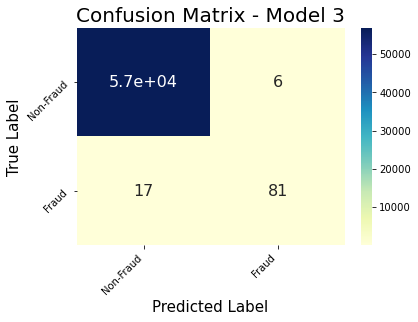

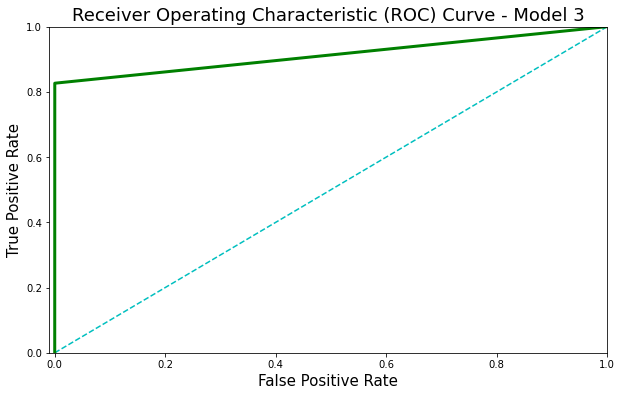

In [43]:
Model_3 = classification_Evaluation_metrics_function(X_test, y_test, vclf, 
                                                 ModelSpe = 'Model 3', metrics_df_flag=True)

## <a id = 6 > 6. Conclusion

In [30]:
Metrics_df = pd.DataFrame(
columns = ['Pos_Precision','Pos_Recall','Pos_F1',
           'ROC-AUC','FN','TP','FP','TN','Precision_at_Recall (85%)'],
index = ['Model 1','Model 3'])

Metrics_df.loc['Model 1'] = Model_1
Metrics_df.loc['Model 3'] = Model_3

Metrics_df

,Pos_Precision,Pos_Recall,Pos_F1,ROC-AUC,FN,TP,FP,TN,Precision_at_Recall (85%)
Model 1,0.941176,0.816327,0.874317,0.96,18,80,5,56859,0.933333
Model 3,0.931034,0.826531,0.875676,0.98,17,81,6,56858,0.857143


###### In summary, the results show that the model without handling class imbalance and hyper-parameter tuning provides higher Precision_at_Recall score.  